In [15]:
import sep
import gzip
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from iminuit import Minuit
from astropy.io import fits
from astropy.visualization import ImageNormalize, ZScaleInterval

sns.set_style('ticks')
sns.set_context('talk')

In [176]:
AMP_EDGES = {0: (0, 1024),
             1: (1024, 2048),
             2: (2048, 3072),
             3: (3072, 4098)}

def get_data(cam, frame, amp):
    """Gets data from specified camera, frame, and amplifer"""
    fname_data = {'frame': frame,
                  'amp': amp}
    if cam == 1:
        fname = './camera1/lbl1.{frame:03d}/lbl1.{frame:03d}{amp:02d}.fits'
        fname = fname.format(**fname_data)
        data = fits.getdata(fname).astype(float)
        data = data[:, :]
    elif cam == 2:
        fname = './camera2/lbl2.{frame:03d}.fits.gz'
        fname = fname.format(**fname_data)
        with gzip.open(fname) as f:
            data = fits.getdata(f).astype(float)
        low, hi = AMP_EDGES[amp]
        data = data[:, low:hi]
    elif cam == 3:
        fname = './camera3/lbl3.{frame:03d}.fits.gz'
        fname = fname.format(**fname_data)
        with gzip.open(fname) as f:
            data = fits.getdata(f).astype(float)
        low, hi = AMP_EDGES[amp]
        data = data[:, low:hi]
    return data

def extract(cam, frame, amp):
    """Uses SEP to remove the background and find objects"""
    data = get_data(cam, frame, amp)
    data = np.array(data)
    bg = sep.Background(data, bw=32, bh=32, maskthresh=1000)
    bg.subfrom(data)
    objs = pd.DataFrame.from_records(sep.extract(data, 5, err=bg.rms(), minarea=1, deblend_nthresh=1))
    objs = objs[objs.flag==0]
    objs = objs[objs.tnpix==1]
    objs.reset_index()
    return objs


def gauss(x, A, mu, sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))


def double_gauss(x, A1, A2, gain, sig1, sig2):
    mu1 = 1620 / gain
    mu2 = 1778 / gain
    return gauss(x, A1, mu1, sig1) + gauss(x, A2, mu2, sig2)


def calc_spec(objs, bins=None):
    """Fits the spectrum of object fluxes to a double Gaussian with
    peaks centered at 1620 and 1778 electrons."""
    if bins is None:
        bins = np.arange(np.min(objs.flux), np.max(objs.flux), 10)
    n, _ = np.histogram(objs.flux, bins=bins)
    x = (bins[1:] + bins[:-1])/2
    
   
    def chisq(A1, A2, gain, sig1, sig2):
        model = double_gauss(x, A1, A2, gain, sig1, sig2)
        diff = model - n
        return np.sum(diff**2)
    
    start = {'A1': len(objs)/8,
             'A2': len(objs)/30,
             'gain': 1620/np.median(objs.flux),
             'sig1': 20,
             'sig2': 50,
             'limit_A1': (0, len(objs)),
             'limit_A2': (0, len(objs)),
             'limit_sig1': (0, 1000),
             'limit_sig2': (0, 1000)}
    m = Minuit(chisq, pedantic=False, print_level=0, **start)
    m.migrad()
    return m.values

def fit_kalpha_line(ys, vals, verbose=False):
    """Fits a line to the K-alpha emission line"""
    kalpha_cut = (vals > 1550) & (vals < 1700)
    ys = ys[kalpha_cut]
    vals = vals[kalpha_cut]
    
    def chisq(slope, intercept):
        model = slope * ys + intercept
        diff = (vals - model)**2
        return np.sum(diff**2)
    
    start = {'slope': 0., 'intercept': 1620}
    m = Minuit(chisq, pedantic=False, print_level=verbose)
    m.migrad()
    
    return m.values, m.errors

def cti(fit, err):
    """Calculates CTI and error"""
    val = fit['slope']/1620
    err = err['slope']/np.sqrt(1620)
    return val, err

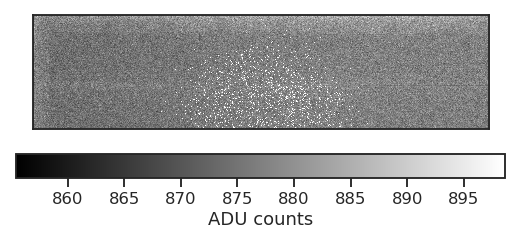

In [177]:
data = get_data(3, 8, 0)
norm = ImageNormalize(data, ZScaleInterval())
plt.figure(figsize=(12, 3))
plt.imshow(data.T, norm=norm, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.colorbar(orientation='horizontal', label='ADU counts')
plt.savefig('../figures/example_xray_image.pdf', bbox_inches='tight')

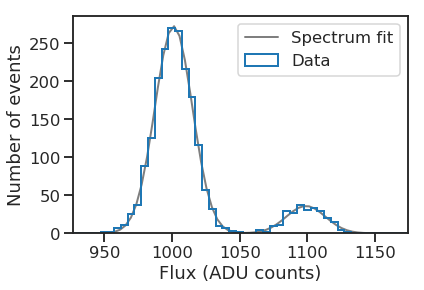

In [178]:
objs = extract(3, 8, 0)
bins = np.arange(objs.flux.min(), objs.flux.max(), 5)
n, bins, _ = plt.hist(objs.flux, bins=bins,
                      histtype='step', linewidth=2, label='Data')
spec_fit = calc_spec(objs, bins)
bins = np.linspace(bins[0], bins[-1], 500)
plt.plot(bins, double_gauss(bins, **spec_fit),
         label='Spectrum fit', color='k', linewidth=2, alpha=0.5, zorder=0)
plt.xlim(1500/spec_fit['gain'], 1900/spec_fit['gain'])
plt.xlabel('Flux (ADU counts)')
plt.ylabel('Number of events')
plt.legend()
plt.savefig('../figures/spectrum_fit.pdf', bbox_inches='tight')

In [198]:
xray_frames = {1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 22, 23, 24, 25],
               2: [100, 101, 102, 103, 106, 119, 121, 124, 125, 127, 128, 133, 134, 135, 138, 139,
                   142, 144, 145, 146, 156, 157, 158, 164, 165, 167],
               3: [2, 4, 8, 9, 10, 11, 12, 13]}
ys = {1: {0: [], 1: []},
      2: {0: [], 1: []},
      3: {0: [], 1: [], 2: [], 3: []}}
xs = {1: {0: [], 1: []},
      2: {0: [], 1: []},
      3: {0: [], 1: [], 2: [], 3: []}}
vals = {1: {0: [], 1: []},
        2: {0: [], 1: []},
        3: {0: [], 1: [], 2: [], 3: []}}
for cam in (3, 2, 1):
    for frame in tqdm(xray_frames[cam]):
        n_amps = 4 if cam == 3 else 2
        for amp in range(n_amps):
            try:
                objs = extract(cam, frame, amp)
            except:
                print(frame, amp)
                continue
            spec_fit = calc_spec(objs)
            vals[cam][amp] += list(objs.flux.values * spec_fit['gain'])
            ys[cam][amp] += list(objs.y.values)
            xs[cam][amp] += list(objs.x.values)

100%|██████████| 22/22 [00:18<00:00,  1.21it/s]


In [199]:
for cam in (1, 2, 3):
    xs[cam] = {k: np.array(v) for k, v in xs[cam].items()}
    ys[cam] = {k: np.array(v) for k, v in ys[cam].items()}
    vals[cam] = {k: np.array(v) for k, v in vals[cam].items()}

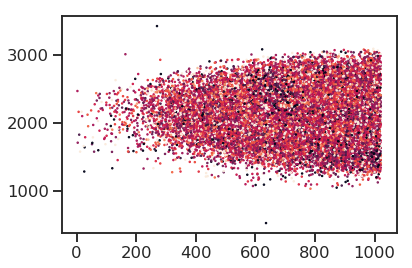

In [200]:
for frame in xray_frames[3]:
    objs = extract(3, frame, 0)
    spec_fit = calc_spec(objs)
    plt.scatter(objs.x.values, objs.y.values, c=objs.flux.values * spec_fit['gain'], s=1,
                vmin=1550, vmax=1700)
# plt.ylim(1550, 1700)

In [201]:
results = {1: {0: None,
               1: None},
           2: {0: None,
               1: None},
           3: {0: None,
               1: None,
               2: None,
               3: None}}
for cam in (1, 2, 3):
    n_amps = 2 if cam < 3 else 4
    for amp in range(n_amps):
        fit_y, err_y = fit_kalpha_line(ys[cam][amp], vals[cam][amp])
        fit_x, err_x = fit_kalpha_line(xs[cam][amp], vals[cam][amp])
        cti_y, cti_err_y = cti(fit_y, err_y)
        cti_x, cti_err_x = cti(fit_x, err_x)
        results[cam][amp] = {'n_hits': len(xs[cam][amp]),
                             'slope_y': fit_y['slope'],
                             'inter_y': fit_y['intercept'],
                             'slope_y_err': err_y['slope'],
                             'inter_y_err': err_y['intercept'],
                             'slope_x': fit_x['slope'],
                             'inter_x': fit_x['intercept'],
                             'slope_x_err': err_x['slope'],
                             'inter_x_err': err_x['intercept'],
                             'cti_y': cti_y,
                             'cti_y_err': cti_err_y,
                             'cti_x': cti_x,
                             'cti_x_err': cti_err_x,}

In [202]:
amp_names = 'ABCD'
cam_names = 'BRP'
print('Cam  Amp  CTI_P  CTI_S  N_hits')
for cam in (1, 2, 3):
    n_amps = 2 if cam < 3 else 4
    for amp in range(n_amps):
        print('{} & {} &{:0.3f} $\;\pm\;$ {:0.3f} & {:0.2f} $\;\pm\;$ {:0.2f} & {} & {:,} \\\\'.format(cam_names[cam-1],
                                                                                                       amp_names[amp],
                                                                                                       np.abs(results[cam][amp]['cti_y']*1e6),
                                                                                                       results[cam][amp]['cti_y_err']*1e6,
                                                                                                       np.abs(results[cam][amp]['cti_x']*1e6),
                                                                                                       results[cam][amp]['cti_x_err']*1e6,
                                                                                                       len(xray_frames[cam]),
                                                                                                       results[cam][amp]['n_hits']))
        


Cam  Amp  CTI_P  CTI_S  N_hits
B & A &0.002 $\;\pm\;$ 0.015 & 0.93 $\;\pm\;$ 0.03 & 22 & 16,278 \\
B & B &0.835 $\;\pm\;$ 0.017 & 0.91 $\;\pm\;$ 0.03 & 22 & 13,464 \\
R & A &1.212 $\;\pm\;$ 0.013 & 12.60 $\;\pm\;$ 0.04 & 26 & 4,542 \\
R & B &0.626 $\;\pm\;$ 0.010 & 8.21 $\;\pm\;$ 0.03 & 26 & 5,192 \\
P & A &1.236 $\;\pm\;$ 0.010 & 4.83 $\;\pm\;$ 0.02 & 8 & 15,372 \\
P & B &0.733 $\;\pm\;$ 0.008 & 1.94 $\;\pm\;$ 0.01 & 8 & 21,005 \\
P & C &0.065 $\;\pm\;$ 0.009 & 5.00 $\;\pm\;$ 0.02 & 8 & 14,528 \\
P & D &0.166 $\;\pm\;$ 0.007 & 3.18 $\;\pm\;$ 0.01 & 8 & 19,129 \\


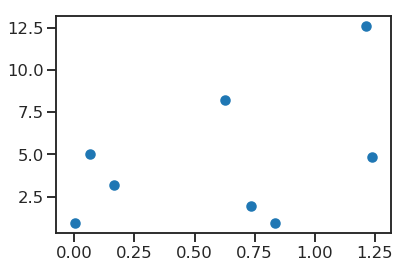

In [203]:
for cam in (1, 2, 3):
    n_amps = 2 if cam < 3 else 4
    for amp in range(n_amps):
        plt.scatter(np.abs(results[cam][amp]['cti_y']*1e6),
                    np.abs(results[cam][amp]['cti_x']*1e6),
                    c='C0')

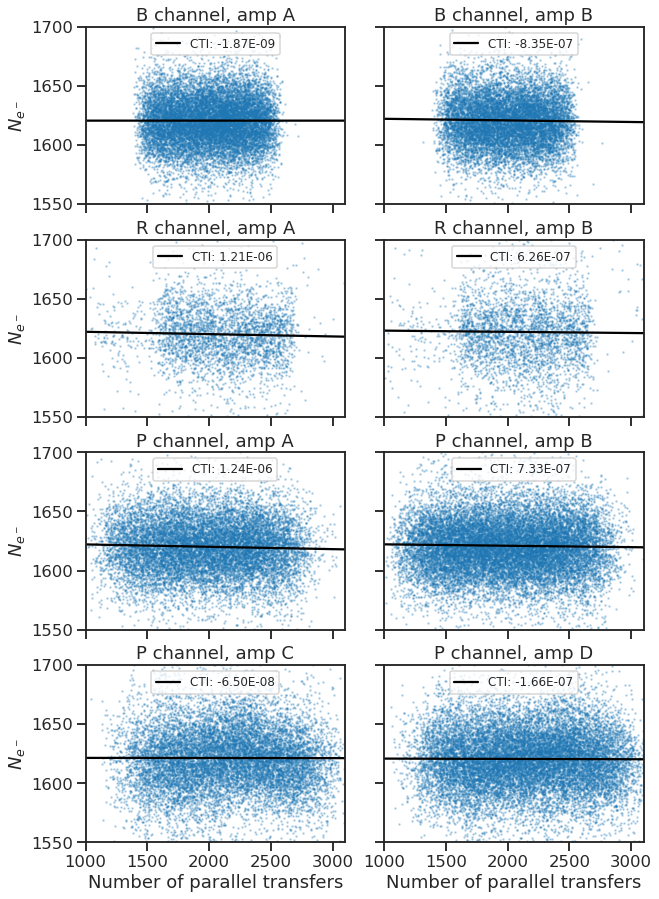

In [204]:
plt.figure(figsize=(10, 15))
for i in range(8):
    plt.subplot(4, 2, i+1)
    cam = int(i/2)+1 if i<4 else 3
    amp = i % 2 if i<4 else i-4
    x = np.linspace(0, 4096, 100)
    if results[cam][amp]['slope_y'] > 0:
        plt.scatter(4096-ys[cam][amp], vals[cam][amp], s=1, alpha=0.3)
        plt.plot(x, results[cam][amp]['slope_y'] * (4096-x) + results[cam][amp]['inter_y'],
                 color='k', label='CTI: {:0.2E}'.format(results[cam][amp]['cti_y']))
    else:
        plt.scatter(ys[cam][amp], vals[cam][amp], s=1, alpha=0.3)
        plt.plot(x, results[cam][amp]['slope_y'] * x + results[cam][amp]['inter_y'],
             color='k', label='CTI: {:0.2E}'.format(results[cam][amp]['cti_y']))
#     plt.axhline(1620, color='k', linestyle='--')
    plt.xlim(1000, 3100)
    plt.ylim(1550, 1700)
    if cam == 3 and amp > 1:
        plt.xlabel('Number of parallel transfers')
    else:
        plt.gca().set_xticklabels([])
    if amp in (0, 2):
        plt.ylabel('$N_{e^-}$')
    else:
        plt.gca().set_yticklabels([])
    plt.legend(loc='upper center', fontsize=12)
    plt.title('{} channel, amp {}'.format('BRP'[cam-1], 'ABCD'[amp]))
plt.subplots_adjust(hspace=0.2, wspace=0.15)
plt.savefig('../figures/xray_cte_parallel.pdf', bbox_inches='tight')

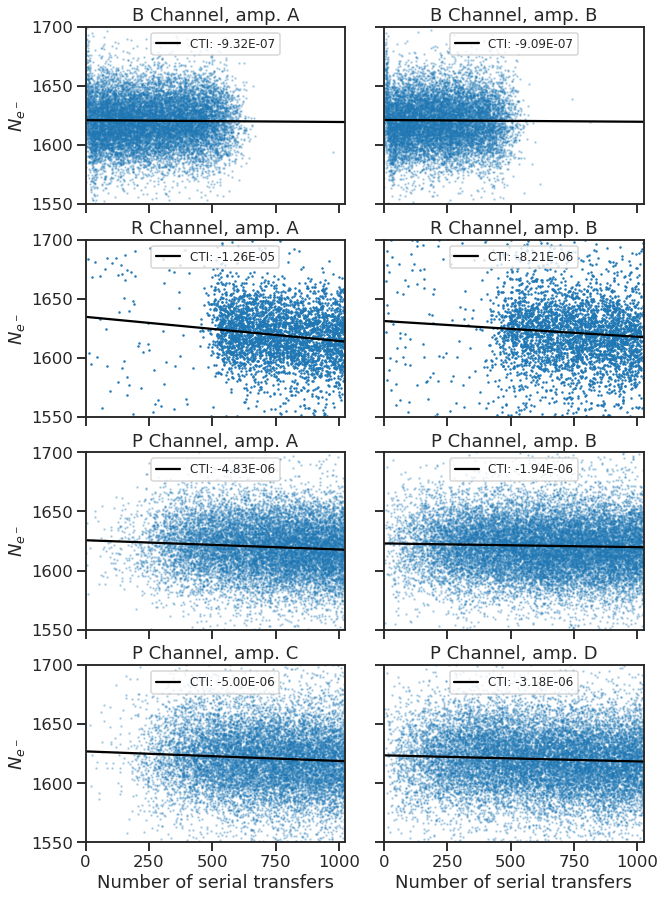

In [205]:
plt.figure(figsize=(10, 15))
for i in range(8):
    plt.subplot(4, 2, i+1)
    cam = int(i/2)+1 if i<4 else 3
    amp = i % 2 if i<4 else i-4
    alpha = 1 if cam == 2 else 0.3
    x = np.linspace(0, 1024, 100)
    if results[cam][amp]['slope_x'] > 0:
        plt.scatter(1024 - xs[cam][amp], vals[cam][amp], s=1, alpha=alpha)
        plt.plot(x, results[cam][amp]['slope_x'] * (1024-x) + results[cam][amp]['inter_x'],
                 color='k', label='CTI: {:0.2E}'.format(-results[cam][amp]['cti_x']))
    else:
        plt.scatter(xs[cam][amp], vals[cam][amp], s=1, alpha=alpha)
        plt.plot(x, results[cam][amp]['slope_x'] * x + results[cam][amp]['inter_x'],
                 color='k', label='CTI: {:0.2E}'.format(results[cam][amp]['cti_x']))
    plt.xlim(0, 1024)
    plt.ylim(1550, 1700)
    if cam == 3 and amp > 1:
        plt.xlabel('Number of serial transfers')
    else:
        plt.gca().set_xticklabels([])
    if amp in (0, 2):
        plt.ylabel('$N_{e^-}$')
    else:
        plt.gca().set_yticklabels([])
    plt.legend(loc='upper center', fontsize=12)
    plt.title('{} Channel, amp. {}'.format('BRP'[cam-1], 'ABCD'[amp]))
plt.subplots_adjust(hspace=0.2, wspace=0.15)
plt.savefig('../figures/xray_cte_serial.pdf', bbox_inches='tight')

# Frame-by-frame fits

To check for consistency, let's fit the CTI on a frame-by-frame basis rather than collecting the data across all frames.

In [206]:
per_frame_results = {1: {0: {},
                         1: {}},
                     2: {0: {},
                         1: {}},
                     3: {0: {},
                         1: {},
                         2: {},
                         3: {}}}
for cam in (3, 2, 1):
    cam_results = {}
    for frame in tqdm(xray_frames[cam]):
        frame_results = {}
        n_amps = 4 if cam == 3 else 2
        for amp in range(n_amps):
            objs = extract(cam, frame, amp)
            spec_fit = calc_spec(objs)
            vals = objs.flux.values * spec_fit['gain']
            xs = objs.x.values
            ys = objs.y.values
            fit_x, err_x = fit_kalpha_line(xs, vals)
            fit_y, err_y = fit_kalpha_line(ys, vals)
            cti_x, cti_err_x = cti(fit_x, err_x)
            cti_y, cti_err_y = cti(fit_y, err_y)
            per_frame_results[cam][amp][frame] = {'n_hits': len(xs),
                                                  'slope_y': fit_y['slope'],
                                                  'inter_y': fit_y['intercept'],
                                                  'slope_y_err': err_y['slope'],
                                                  'inter_y_err': err_y['intercept'],
                                                  'slope_x': fit_x['slope'],
                                                  'inter_x': fit_x['intercept'],
                                                  'slope_x_err': err_x['slope'],
                                                  'inter_x_err': err_x['intercept'],
                                                  'cti_y': cti_y,
                                                  'cti_y_err': cti_err_y,
                                                  'cti_x': cti_x,
                                                  'cti_x_err': cti_err_x,}

100%|██████████| 22/22 [00:18<00:00,  1.05it/s]


In [207]:
for cam in (1, 2, 3):
    n_amps = 4 if cam == 3 else 2
    for amp in range(n_amps):
        cti_y = results[cam][amp]['cti_y']
        cti_y_err = results[cam][amp]['cti_y_err']
        pf_cti_y = [frame['cti_y'] for frame in per_frame_results[cam][amp].values()]
        pf_cti_y_err = [frame['cti_y_err'] for frame in per_frame_results[cam][amp].values()]
        pf_ave_cti_y = np.average(pf_cti_y, weights=1/np.array(pf_cti_y_err))
        print('Parallel, Camera {}, Amp. {}'.format(cam, amp))
        print('  Single fit:         {:0.2e} +/- {:0.2e}'.format(cti_y, cti_y_err))
        print('  Weighted ave. fits: {:0.2e}'.format(pf_ave_cti_y))
        print()

Parallel, Camera 1, Amp. 0
  Single fit:         -1.87e-09 +/- 1.50e-08
  Weighted ave. fits: -1.43e-07

Parallel, Camera 1, Amp. 1
  Single fit:         -8.35e-07 +/- 1.69e-08
  Weighted ave. fits: -9.90e-07

Parallel, Camera 2, Amp. 0
  Single fit:         1.21e-06 +/- 1.30e-08
  Weighted ave. fits: 2.20e-06

Parallel, Camera 2, Amp. 1
  Single fit:         6.26e-07 +/- 1.01e-08
  Weighted ave. fits: 1.06e-06

Parallel, Camera 3, Amp. 0
  Single fit:         1.24e-06 +/- 9.65e-09
  Weighted ave. fits: 1.02e-06

Parallel, Camera 3, Amp. 1
  Single fit:         7.33e-07 +/- 7.95e-09
  Weighted ave. fits: 3.22e-07

Parallel, Camera 3, Amp. 2
  Single fit:         -6.50e-08 +/- 8.53e-09
  Weighted ave. fits: -8.43e-08

Parallel, Camera 3, Amp. 3
  Single fit:         -1.66e-07 +/- 7.41e-09
  Weighted ave. fits: -2.44e-07



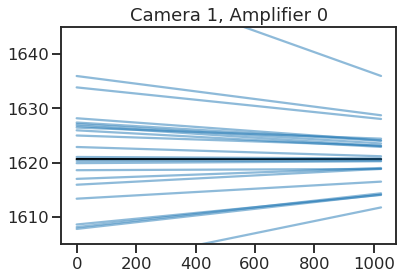

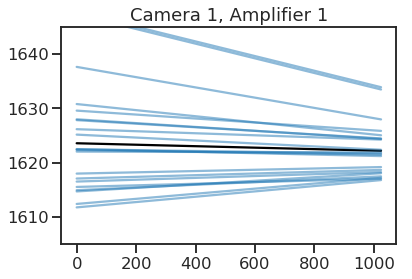

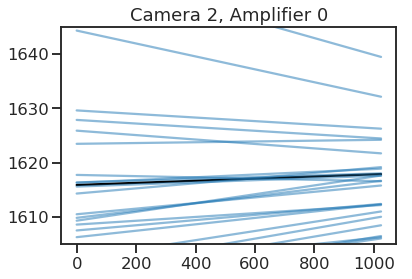

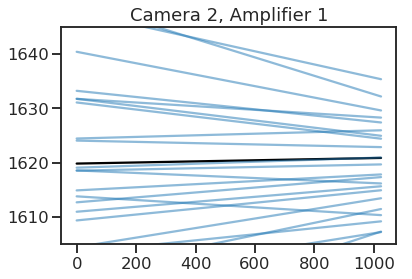

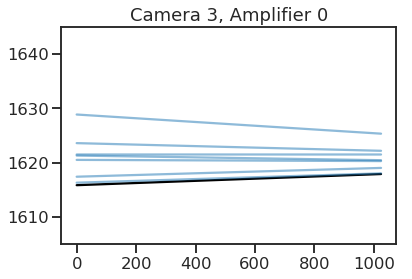

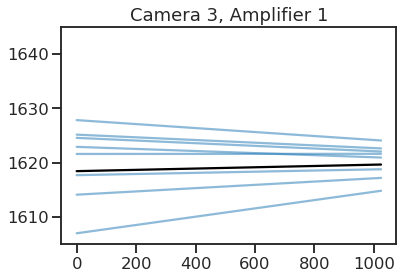

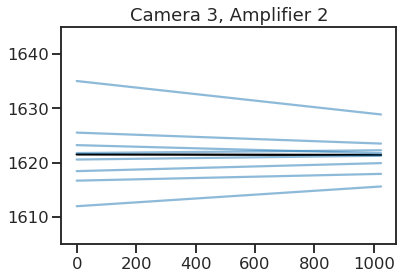

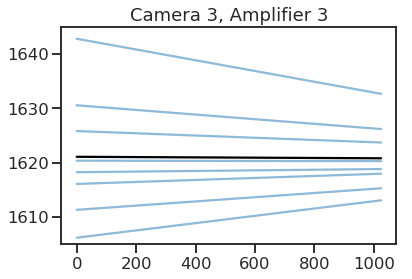

In [208]:
x = np.linspace(0, 1024)
for cam in (1, 2, 3):
    n_amps = 4 if cam == 3 else 2
    for amp in range(n_amps):
        slope = results[cam][amp]['slope_y']
        inter = results[cam][amp]['inter_y']
        plt.plot(x, slope*x + inter, color='k')
        for frame in per_frame_results[cam][amp].values():
            plt.plot(x, frame['slope_y'] * x + frame['inter_y'], color='C0', alpha=0.5)
        plt.title('Camera {}, Amplifier {}'.format(cam, amp))
        plt.ylim(1605, 1645)
        plt.show()

In [209]:
pf_df = []
for camera, camera_res in per_frame_results.items():
    for amp, amp_res in camera_res.items():
        for frame, frame_res in amp_res.items():
            d = frame_res
            d['camera'] = camera
            d['amp'] = amp
            d['frame'] = frame
            pf_df.append(d)
pf_df = pd.DataFrame(pf_df)

In [210]:
pf_df.to_csv('per_frame_xray_results.csv')

In [211]:
df = []
for camera, camera_res in results.items():
    for amp, amp_res in camera_res.items():
        d = amp_res
        d['camera'] = camera
        d['amp'] = amp
        df.append(d)
df = pd.DataFrame(df)

In [212]:
df.to_csv('combined_xray_results.csv')